In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

### Autoencoder with Conv2DTranspose

In [3]:
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape = (28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters = 32,
                kernel_size = 3,
                strides = 2,
                activation = 'relu'),
            tf.keras.layers.Conv2D(
                filters = 64,
                kernel_size = 3,
                strides = 2,
                activation = 'relu'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(10)])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape = (10)),
            tf.keras.layers.Dense(7 * 7 * 32, activation = 'relu'),
            tf.keras.layers.Reshape((7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(filters = 64,
                kernel_size = 3,
                strides = (2, 2),
                padding = "SAME",
                activation = 'relu'),
            tf.keras.layers.Conv2DTranspose(
                filters = 32,
                kernel_size = 3,
                strides = 2,
                padding = "SAME",
                activation = 'relu'),
            tf.keras.layers.Conv2DTranspose(
                filters = 1,
                kernel_size = 3,
                strides = 1,
                padding = "SAME",
                activation = 'sigmoid')])
        self.loss_function = tf.keras.losses.binary_crossentropy
        self.optimizer = tf.keras.optimizers.Adam()
        self.create_checkpoint()
        
    def create_checkpoint(self, path = './model/checkpoint'):
        self.path = path
        self.ckpt = tf.train.Checkpoint(model = self)
        self.ckpt_manager = tf.train.CheckpointManager(
        self.ckpt, self.path, max_to_keep = 1)
        
    def save(self):
        self.ckpt_manager.save()
        
    def restore(self):
        self.ckpt.restore(self.ckpt_manager.latest_checkpoint)
        
    def decode(self, encodings):
        return self.decoder(encodings)
    
    def encode(self, inputs):
        return self.encoder(inputs)
    
    def reconstruct(self, inputs):
        return self.decoder(self.encoder(inputs))
    
    def fit_iteration(self, inputs, target):
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            reconstructions = self.reconstruct(inputs)
            loss = tf.reduce_sum(
                self.loss_function(target, reconstructions))
            self.optimizer.apply_gradients(zip(
                tape.gradient(loss, self.trainable_variables), self.trainable_variables))
            return loss
            
        
    def fit(self, dataset, y=None, epochs = 1, steps_per_epoch = 1):
        dataset = iter(dataset)
        if y is not None:
            y= iter(y)
        for epoch_n in range(epochs):
            for iteration_n in range(steps_per_epoch):
                inputs = next(dataset)
                if y is not None:
                    target = next(y)
                else:
                    target = inputs
                loss = self.fit_iteration(inputs,target)
            print(
            f'Epoch {epoch_n}: ' +
            f'{np.round((iteration_n + 1) / steps_per_epoch * 100, 2)}%, ' +
            f'loss: {loss}',
            end = '\r'
            )
            print('')

### Autoencoder with Upsampling layers

In [4]:
class AutoencoderUpsampling(Autoencoder):
    def __init__(self):
        super(AutoencoderUpsampling, self).__init__()
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape = (10)),
            tf.keras.layers.Dense(7 * 7 * 32, activation = 'relu'),
            tf.keras.layers.Reshape((7, 7, 32)),
            tf.keras.layers.UpSampling2D(size=(2, 2)),
            tf.keras.layers.Conv2D(filters = 64,
                kernel_size = 3,
                strides = 1,
                padding='same',
                activation = 'relu'),
            tf.keras.layers.UpSampling2D(size=(2, 2)),
            tf.keras.layers.Conv2D(filters = 32,
                kernel_size = 3,
                strides = 1,
                padding='same',
                activation = 'relu'),
           # tf.keras.layers.UpSampling2D(size=(2, 2)),
            tf.keras.layers.Conv2D(filters = 1,
                kernel_size = 3,
                strides = 1,
                padding = "SAME",
                activation = 'sigmoid'),])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Ahmad Wali\tensorflow_datasets\mnist\3.0.1.incomplete9219V5\mnist-train.tfrecord*...:   0%|…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Ahmad Wali\tensorflow_datasets\mnist\3.0.1.incomplete9219V5\mnist-test.tfrecord*...:   0%| …

Dataset mnist downloaded and prepared to C:\Users\Ahmad Wali\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.
Epoch 0: 100.0%, loss: 5780.2646484375
Epoch 1: 100.0%, loss: 5466.130859375


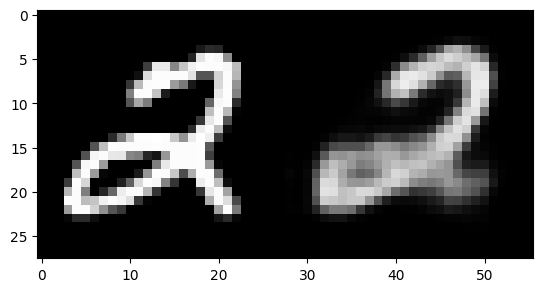

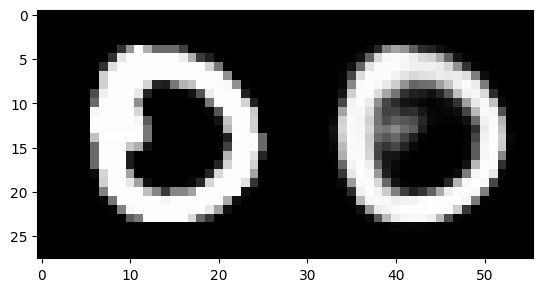

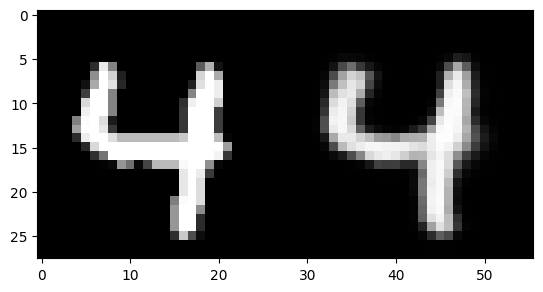

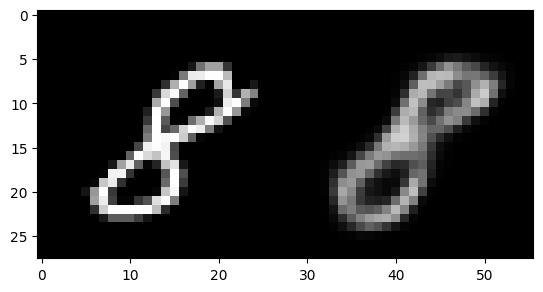

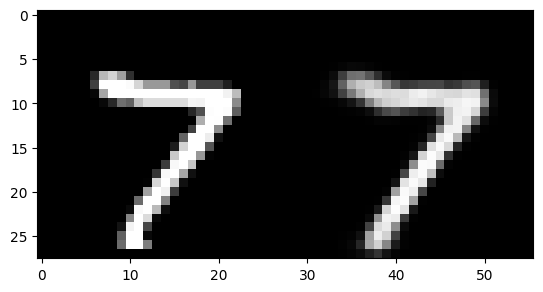

In [5]:
dataset, meta = tfds.load('mnist',
    as_supervised = True,
    with_info = True
    )
def normalize(image, label):
    processed_image = tf.cast(image, tf.float32) / 255.
    return processed_image
batch_size = 64
train_ds = dataset['train'].map(normalize)
n_samples = meta.splits['train'].num_examples
steps_per_epoch = n_samples // batch_size

model = Autoencoder()
# model = AutoencoderUpsampling()
model.fit(
    train_ds.batch(batch_size).shuffle(100000).repeat(),
    epochs = 2,
    steps_per_epoch = steps_per_epoch
)

model.save()
# model.restore()
sample_dataset = iter(dataset['test'].map(normalize).batch(1))
for sample_n in range(5):
    original = next(sample_dataset)
    reconstruction = model.reconstruct(original)
    original = np.reshape(original, (28, 28))
    reconstruction = np.reshape(reconstruction, (28, 28))
    plt.imshow(
        np.concatenate([original, reconstruction], axis = -1),
        cmap = 'gray')
    plt.show()

### Denoising Autoencoder

Epoch 0: 100.0%, loss: 6161.900390625
Epoch 1: 100.0%, loss: 6069.0927734375
Epoch 2: 100.0%, loss: 6326.1884765625
Epoch 3: 100.0%, loss: 5917.21875


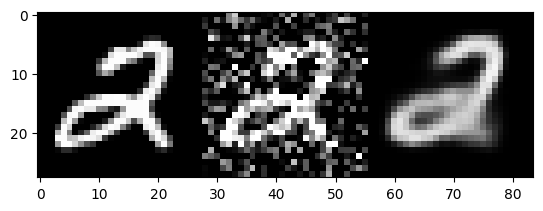

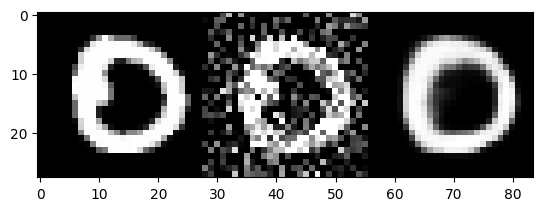

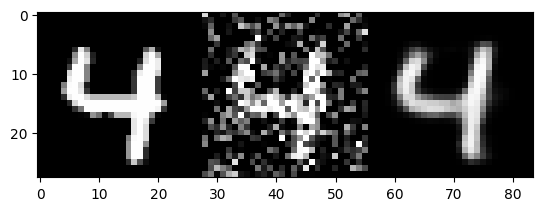

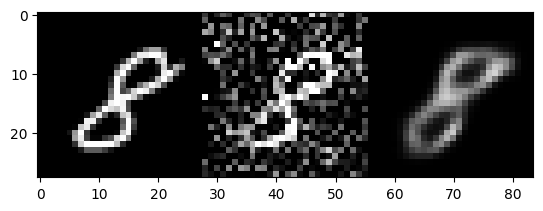

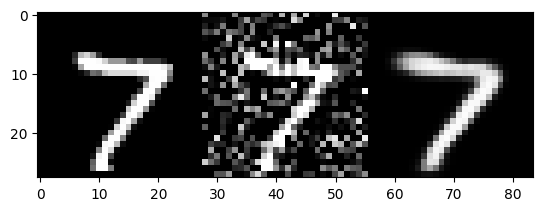

In [6]:
def normalize_noise(image, label):
    image = tf.cast(image, tf.float32) / 255.
    noise_factor = 0.4
    noisy_image = image + noise_factor * tf.random.normal(
        mean=0.0, stddev=1.0, shape=image.shape
    )

    return tf.clip_by_value(noisy_image, 0.0, 1.0)
dataset, meta = tfds.load('mnist',
    as_supervised = True,
    with_info = True
    )

noisy_train = dataset['train'].map(normalize_noise)
noisy_test = dataset['test'].map(normalize_noise)
train_dataset = dataset['train'].map(normalize)
test_dataset = dataset['test'].map(normalize)
model = Autoencoder()
model.fit(
    noisy_train.batch(batch_size).repeat(),
    train_dataset.batch(batch_size).repeat(),
    epochs = 4,
    steps_per_epoch = steps_per_epoch
)

noisy_sample_dataset = iter(noisy_test.batch(1))
sample_dataset = iter(test_dataset.batch(1))
for sample_n in range(5):
    original = next(sample_dataset)
    noisy = next(noisy_sample_dataset)
    reconstruction = model.reconstruct(noisy)
    original = np.reshape(original, (28, 28))
    reconstruction = np.reshape(reconstruction, (28, 28))
    noisy = np.reshape(noisy,(28,28))
    plt.imshow(
        np.concatenate([original,noisy, reconstruction], axis = -1),
        cmap = 'gray')
    plt.show()

In [7]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

ae_classifier = tf.keras.Sequential([
            model.encoder,
            tf.keras.layers.Dense(10,activation='softmax')])
ae_classifier.layers[0].trainable=False
ae_classifier.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
ae_classifier.fit(x_train,y_train,epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test, y_test),)


Epoch 1/10
469/469 [==============================] - 2s 3ms/step - loss: 391.2844 - accuracy: 0.3689 - val_loss: 69.3981 - val_accuracy: 0.6491
Epoch 2/10
469/469 [==============================] - 1s 3ms/step - loss: 39.5135 - accuracy: 0.7618 - val_loss: 23.3856 - val_accuracy: 0.8247
Epoch 3/10
469/469 [==============================] - 1s 3ms/step - loss: 19.9771 - accuracy: 0.8389 - val_loss: 15.8443 - val_accuracy: 0.8559
Epoch 4/10
469/469 [==============================] - 1s 3ms/step - loss: 13.9420 - accuracy: 0.8601 - val_loss: 11.5665 - val_accuracy: 0.8688
Epoch 5/10
469/469 [==============================] - 1s 3ms/step - loss: 10.0244 - accuracy: 0.8691 - val_loss: 8.3934 - val_accuracy: 0.8728
Epoch 6/10
469/469 [==============================] - 1s 3ms/step - loss: 7.0101 - accuracy: 0.8750 - val_loss: 5.8752 - val_accuracy: 0.8782
Epoch 7/10
469/469 [==============================] - 1s 3ms/step - loss: 4.6947 - accuracy: 0.8743 - val_loss: 3.8740 - val_accuracy: 0.8

### Variational Autoencoder

In [8]:
class VAE(Autoencoder):
    def __init__(self):
        super(VAE, self).__init__()
        in_img = tf.keras.Input(shape = (28, 28, 1))
        x = tf.keras.layers.Conv2D(
                filters = 32,
                kernel_size = 3,
                strides = 2,
                activation = 'relu')(in_img)
        x = tf.keras.layers.Conv2D(
                filters = 64,
                kernel_size = 3,
                strides = 2,
                activation = 'relu')(x)
        x = tf.keras.layers.Flatten()(x)
        mean = tf.keras.layers.Dense(10)(x)
        var = tf.keras.layers.Dense(10)(x)
        self.encoder = tf.keras.Model(in_img, [mean, var])
    
    def reconstruct(self,inputs):
        mean, var = self.encoder(inputs)
        epsilon = tf.random.normal(shape=mean.shape, mean=0.0, stddev=1.0)
        latent = mean + tf.sqrt(tf.exp(var)) * epsilon
        reconstructions = self.decoder(latent)
        return mean,var,reconstructions
    
    def fit(self, dataset, y=None, epochs = 1, steps_per_epoch = 1):
        dataset = iter(dataset)
        if y is not None:
            y= iter(y)
        for epoch_n in range(epochs):
            for iteration_n in range(steps_per_epoch):
                inputs = next(dataset)
                if y is not None:
                    target = next(y)
                else:
                    target = inputs
                loss, kl_loss = self.fit_iteration(inputs,target)
            print(
            f'Epoch {epoch_n}: ' +
            f'{np.round((iteration_n + 1) / steps_per_epoch * 100, 2)}%, ' +
            f'loss: {loss}',
            f'kl_loss:{kl_loss}',
            end = '\r'
            )
            print('')
    def fit_iteration(self, inputs, target):
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            mean, var, reconstructions = self.reconstruct(inputs)
            loss = tf.reduce_sum(
                self.loss_function(target, reconstructions))

            kl_loss = -0.5*var + 0.5*(tf.exp(var) + tf.square(mean)) - 0.5
            kl_loss = tf.reduce_sum(tf.reduce_sum(kl_loss, axis=1))
            # print(kl_loss)
            # print(loss)
            total_loss = loss + kl_loss
            self.optimizer.apply_gradients(zip(
                tape.gradient(total_loss, self.trainable_variables), self.trainable_variables))
            return loss, kl_loss
            
        
        

In [9]:
train_dataset = dataset['train'].map(normalize)
test_dataset = dataset['test'].map(normalize)
model = VAE()
model.fit(
    train_dataset.batch(batch_size).repeat(),
    epochs = 50,
    steps_per_epoch = steps_per_epoch
)


Epoch 0: 100.0%, loss: 5629.775390625 kl_loss:1115.857666015625
Epoch 1: 100.0%, loss: 5788.97802734375 kl_loss:1148.898193359375
Epoch 2: 100.0%, loss: 6002.2255859375 kl_loss:1184.945556640625
Epoch 3: 100.0%, loss: 5521.0625 kl_loss:1187.8173828125
Epoch 4: 100.0%, loss: 5899.8564453125 kl_loss:1172.6943359375
Epoch 5: 100.0%, loss: 5590.376953125 kl_loss:1203.632080078125
Epoch 6: 100.0%, loss: 5076.240234375 kl_loss:1197.488037109375
Epoch 7: 100.0%, loss: 5741.0400390625 kl_loss:1302.7730712890625
Epoch 8: 100.0%, loss: 5819.083984375 kl_loss:1233.06640625
Epoch 9: 100.0%, loss: 5490.79736328125 kl_loss:1236.9310302734375
Epoch 10: 100.0%, loss: 5412.49951171875 kl_loss:1190.2025146484375
Epoch 11: 100.0%, loss: 5174.4462890625 kl_loss:1194.4052734375
Epoch 12: 100.0%, loss: 5342.9365234375 kl_loss:1226.356689453125
Epoch 13: 100.0%, loss: 5328.783203125 kl_loss:1210.029541015625
Epoch 14: 100.0%, loss: 5367.30126953125 kl_loss:1242.233642578125
Epoch 15: 100.0%, loss: 5356.11425

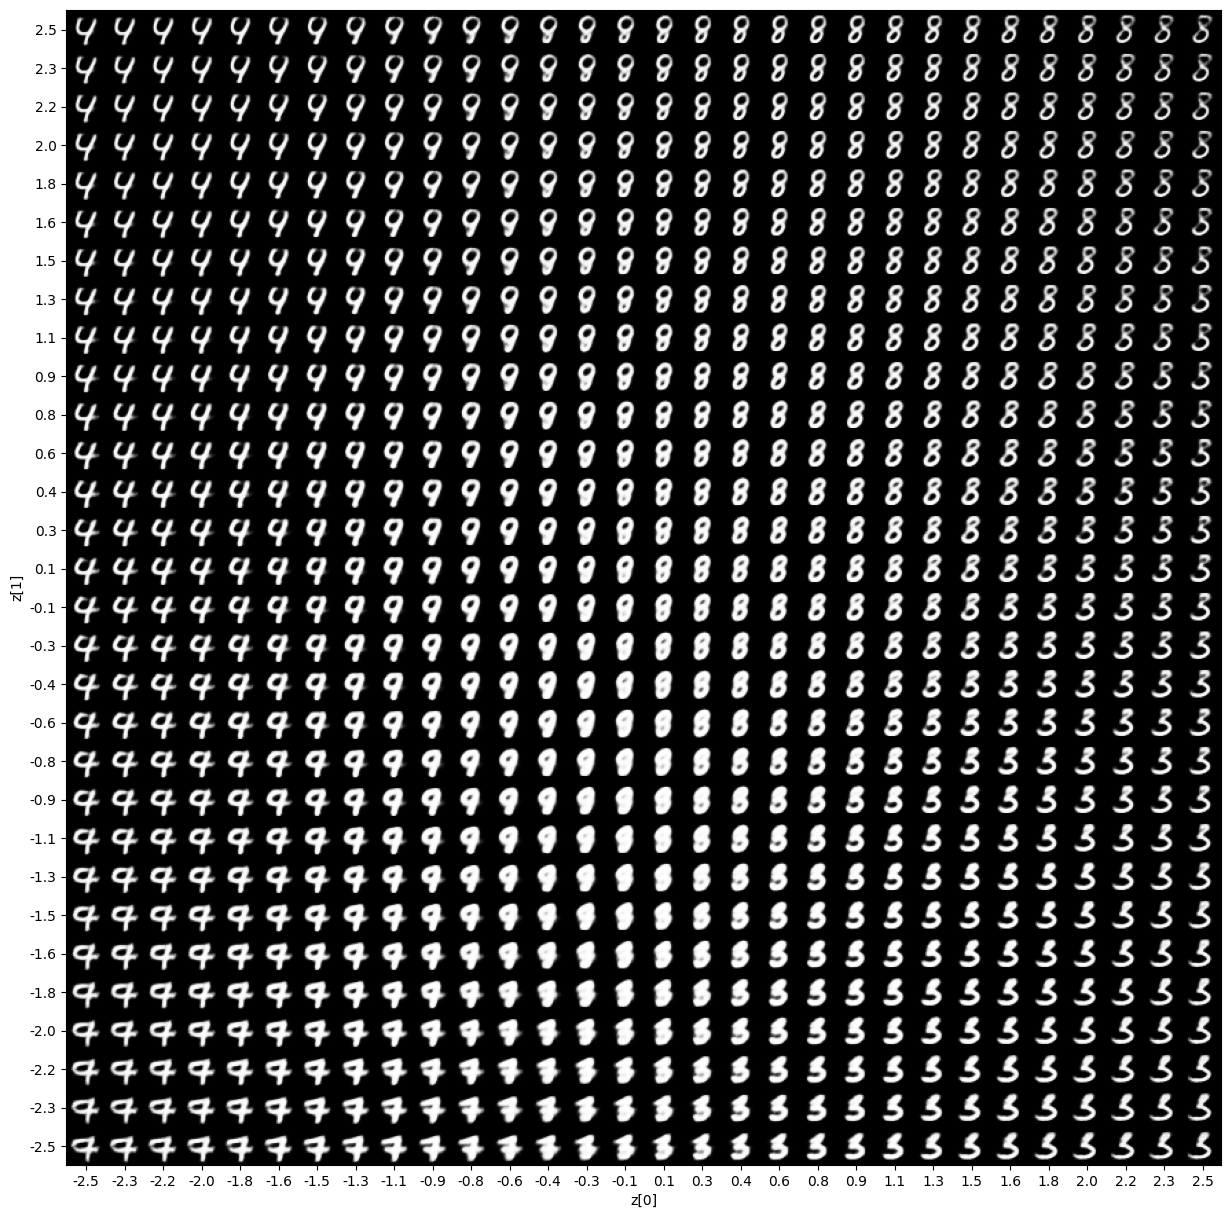

In [10]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 2.5
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi, 0, 0,0,0,0,0,0,0]])
            x_decoded = vae.decode(z_sample)
            digit = np.reshape(x_decoded, (28, 28))
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)

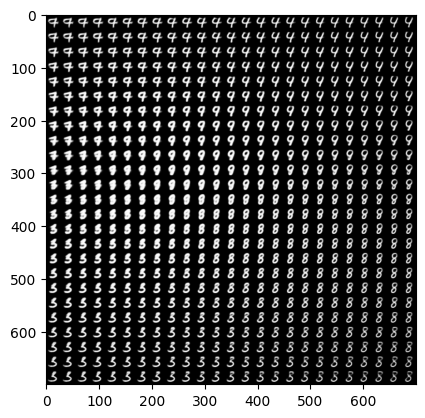

In [11]:
n_samples = 25
limit = 2.5
all_samples = np.zeros(
shape = (n_samples * 28, n_samples * 28),
dtype = np.float32
)
for i, x in enumerate(np.linspace(-limit, limit, n_samples)):
    for j, y in enumerate(np.linspace(-limit, limit, n_samples)):
        im = model.decode(np.array([[x, y, 0, 0, 0, 0, 0, 0, 0, 0]]))
        im = np.reshape(im, (28, 28))
        all_samples[
            i * 28: (i + 1) * 28,
            j * 28: (j + 1) * 28
            ] = im
plt.imshow(all_samples, cmap = 'gray')
plt.show()